# SP100list 时间序列数据预测

在以下的预测的python程序中，分别选取了时间序列与机器学习的相关算法，对数据分别进行预测，并将预测结果进行比对，选出较好的预测算法。

时间序列算法包括：**AR模型，Theta模型，Damp Trend模型**，其中AR和Theta均包括了单噪声模型（SSOE）和双噪声模型（MSOE），Damp Trend只包括了单噪声模型（SSOE）

机器学习算法包括：**神经网络（NN），K临近法（KNN），回归树（RT）和以回归树为基础的随机森林（RF)**

首先我们先用python构建出这些算法对应的函数：

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.optimize import minimize
import math
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeRegressor
import warnings


def ForecastARkf(y, h):
    n = len(y)
    a, p, k, v = [np.ones(n) for _ in range(4)]
    a[0], p[0] = y[0], 10000

    def fu(mypa):
        q, co, w = abs(mypa[0]), abs(mypa[1]), 1-math.exp(-abs(mypa[2]))
        z = 1
        likelihood = sigmae = 0
        for t in range(1, n):
            k[t] = (z * w * p[t - 1]) / (pow(z, 2) * p[t - 1] + 1)
            p[t] = pow(w, 2) * p[t - 1] - w * z * k[t] * p[t - 1] + q
            v[t] = y[t] - z * a[t - 1]
            a[t] = co + w * a[t - 1] + k[t] * v[t]
            sigmae += (pow(v[t], 2) / (pow(z, 2) * p[t - 1] + 1))
            likelihood += .5 * math.log(2 * math.pi) + .5 + .5 * math.log(pow(z, 2) * p[t - 1] + 1)
        return likelihood + .5 * n * math.log(sigmae / n)

    results = minimize(fu, [.2, 1, 2])
    v[0], z = 0, 1
    q, co, w, sigmae = abs(results.x[0]), results.x[1], 1-math.exp(-abs(results.x[2])), 0
    for t in range(1, n):
        k[t] = (z * w * p[t - 1]) / (pow(z, 2) * p[t - 1] + 1)
        p[t] = pow(w, 2) * p[t - 1] - w * z * k[t] * p[t - 1] + q
        v[t] = y[t] - z * a[t - 1]
        a[t] = co + w * a[t - 1] + k[t] * v[t]
        sigmae = sigmae + pow(v[t], 2) / (pow(z, 2) * p[t - 1] + 1)
    Forec = np.array([a[len(y)-1]])
    for i in range(1, h):
        Forec = np.append(Forec, co+w*Forec[i-1])
    return Forec


def ForecastAR(y, h):
    state = 0*np.ones(len(y))
    v = 0*np.ones(len(y))
    state[0] = y[0]

    def logLikConc(myparam):
        w, gamma, co = 1 - math.exp(-abs(myparam[0])), abs(myparam[1]), abs(myparam[2])
        for t in range(1, len(y)):
            v[t] = y[t]-state[t-1]
            state[t] = co+w*state[t-1]+gamma*v[t]
        temp = np.sum(np.power(v[1:len(y)], 2))
        return temp

    result = minimize(logLikConc, [2, .2, 1])
    w, gamma, co = 1 - math.exp(-abs(result.x[0])), abs(result.x[1]), abs(result.x[2])
    for t in range(1, len(y)):
        v[t] = y[t] - state[t - 1]
        state[t] = co + w * state[t - 1] + gamma * v[t]
    Forec = np.array([state[len(y) - 1]])
    for i in range(1, h):
        Forec = np.append(Forec, co + w * Forec[i - 1])
    return Forec


def ForecastTheta(y, h):
    state = 0 * np.ones(len(y))
    v = 0 * np.ones(len(y))
    state[0] = y[0]

    def logLikConc(myparam):
        w, gamma, co = 1, abs(myparam[0]), abs(myparam[1])
        for t in range(1, len(y)):
            v[t] = y[t]-state[t-1]
            state[t] = co+w*state[t-1]+gamma*v[t]
        temp = np.sum(np.power(v[1:len(y)], 2))
        return temp

    result = minimize(logLikConc, [.3, 1])
    w, gamma, co = 1, abs(result.x[0]), abs(result.x[1])
    for t in range(1, len(y)):
        v[t] = y[t] - state[t - 1]
        state[t] = co + w * state[t - 1] + gamma * v[t]
    Forec = np.array([state[len(y) - 1]])
    for i in range(1, h):
        Forec = np.append(Forec, co + w * Forec[i - 1])
    return Forec


def ForecastThetakf(y, h):
    n = len(y)
    a, p, k, v = [np.ones(n) for _ in range(4)]
    a[0], p[0], v[0] = y[0], 10000, 0

    def funcTheta(parameters):
        q, co = abs(parameters[0]), abs(parameters[1])
        z = w = 1
        likelihood = sigmae = 0
        for t in range(1, n):
            k[t] = (z * w * p[t - 1]) / (pow(z, 2) * p[t - 1] + 1)
            p[t] = pow(w, 2) * p[t - 1] - w * z * k[t] * p[t - 1] + q
            v[t] = y[t] - z * a[t - 1]
            a[t] = co + w * a[t - 1] + k[t] * v[t]
            sigmae += (pow(v[t], 2) / (pow(z, 2) * p[t - 1] + 1))
            likelihood += .5 * math.log(2 * math.pi) + .5 + .5 * math.log(pow(z, 2) * p[t - 1] + 1)
        return likelihood + .5 * n * math.log(sigmae / n)

    results = minimize(funcTheta, [.3, 1])
    q, co = abs(results.x[0]), abs(results.x[1])
    z = w = 1
    for t in range(1, n):
        k[t] = (z * w * p[t - 1]) / (pow(z, 2) * p[t - 1] + 1)
        p[t] = pow(w, 2) * p[t - 1] - w * z * k[t] * p[t - 1] + q
        v[t] = y[t] - z * a[t - 1]
        a[t] = co + w * a[t - 1] + k[t] * v[t]
    Forecast = np.array([a[len(y) - 1]])
    for i in range(1, h):
        Forecast = np.append(Forecast, co + w * Forecast[i - 1])
    return Forecast


def ForecastDamped(y, h):
    obs = len(y)
    damped = 0*np.ones([obs, 2])
    damped[0, 0] = y[0]
    damped[0, 1] = 0
    inn = 0*np.ones(obs)

    def fmsoe(param):
        k1, k2, k3 = abs(param[0]), abs(param[1]), abs(param[2])
        for t in range(1, obs):
            inn[t] = y[t]-damped[t-1, 0]-k3*damped[t-1, 1]
            damped[t, 0] = damped[t-1, 0]+k3*damped[t-1, 1]+k1*inn[t]
            damped[t, 1] = k3*damped[t-1, 1]+k2*inn[t]
        temp = np.sum(np.power(inn, 2)/obs)
        return temp

    result = minimize(fmsoe, np.random.uniform(0, 1, 3))
    k1, k2, k3 = abs(result.x[0]), abs(result.x[1]), abs(result.x[2])
    if k3 > 1:
        k3 = 1
    for t in range(1, obs):
        inn[t] = y[t] - damped[t - 1, 0] - k3 * damped[t - 1, 1]
        damped[t, 0] = damped[t - 1, 0] + k3 * damped[t - 1, 1] + k1 * inn[t]
        damped[t, 1] = k3 * damped[t - 1, 1] + k2 * inn[t]
    Forecast = np.array([damped[obs-1, 0]+k3 * damped[obs-1, 1]])
    for i in range(1, h):
        Forecast = np.append(Forecast, Forecast[i - 1] + damped[obs-1, 1] * np.power(k3, i))
    return Forecast


def ForecastRF(y, h):
    n = len(y)
    k = 3
    data = np.ones([n-k, k+1])
    for i in range(n-k):
        data[i] = y[i:i+k+1]
    np.random.shuffle(data)
    xtrain = data[:, :k]
    ytrain = data[:, k].astype('int')
    ml = RandomForestClassifier(n_estimators=10)
    ml.fit(xtrain, ytrain)
    Forec = np.ones(h)
    Forec[0] = ml.predict(np.array(y[-k:]).reshape(1, -1))
    for i in range(1, h):
        if i < k:
            Forec[i] = ml.predict(np.append(y[-k+i:], Forec[:i]).reshape(1, -1))
        else:
            Forec[i] = ml.predict(np.array(Forec[i-k:i]).reshape(1, -1))
    return Forec


def ForecastNN(y, h):
    n = len(y)
    k = 3
    data = np.ones([n-k, k+1])
    for i in range(n-k):
        data[i] = y[i:i+k+1]
    np.random.shuffle(data)
    xtrain = data[:, :k]
    ytrain = data[:, k].astype('int')
    ml = MLPClassifier()
    ml.fit(xtrain, ytrain)
    Forec = np.ones(h)
    Forec[0] = ml.predict(np.array(y[-k:]).reshape(1, -1))
    for i in range(1, h):
        if i < k:
            Forec[i] = ml.predict(np.append(y[-k+i:], Forec[:i]).reshape(1, -1))
        else:
            Forec[i] = ml.predict(np.array(Forec[i-k:i]).reshape(1, -1))
    return Forec


def ForecastKNN(y, h):
    n = len(y)
    k = 3
    data = np.ones([n-k, k+1])
    for i in range(n-k):
        data[i] = y[i:i+k+1]
    np.random.shuffle(data)
    xtrain = data[:, :k]
    ytrain = data[:, k].astype('int')
    ml = KNeighborsClassifier()
    ml.fit(xtrain, ytrain)
    Forec = np.ones(h)
    Forec[0] = ml.predict(np.array(y[-k:]).reshape(1, -1))
    for i in range(1, h):
        if i < k:
            Forec[i] = ml.predict(np.append(y[-k+i:], Forec[:i]).reshape(1, -1))
        else:
            Forec[i] = ml.predict(np.array(Forec[i-k:i]).reshape(1, -1))
    return Forec


def ForecastRT(y, h):
    n = len(y)
    k = 3
    data = np.ones([n-k, k+1])
    for i in range(n-k):
        data[i] = y[i:i+k+1]
    np.random.shuffle(data)
    xtrain = data[:, :k]
    ytrain = data[:, k]
    ml = DecisionTreeRegressor()
    ml.fit(xtrain, ytrain)
    Forec = np.ones(h)
    Forec[0] = ml.predict(np.array(y[-k:]).reshape(1, -1))
    for i in range(1, h):
        if i < k:
            Forec[i] = ml.predict(np.append(y[-k+i:], Forec[:i]).reshape(1, -1))
        else:
            Forec[i] = ml.predict(np.array(Forec[i-k:i]).reshape(1, -1))
    return Forec

接着我们读取对应的csv数据，以每周为单位，将已有的数据用于模型的训练，并预测六周的数据。

In [2]:
data = pd.read_csv('SP100list.csv')
n = len(data)//7
MM = pd.DataFrame(np.ones([101, n]))
for i in range(n):
    MM[:][i] = np.array(data.iloc[i*7][:])

warnings.filterwarnings('ignore')
replic = len(MM)
mlist = ['AR', 'ARkf', 'Theta', 'Thetakf', 'Damped', 'NN', 'KNN', 'RT', 'RF']
mcount = len(mlist)
steps = 6
for i in range(mcount):
    locals()['Method' + str(i+1)] = 0 * np.ones([replic, steps])
    locals()['Err' + str(i+1)] = 0 * np.ones([replic, steps])
    locals()['sErr' + str(i+1)] = 0 * np.ones([replic, steps])

for g in range(replic):
    y = np.array(MM.iloc[g][:])
    y = np.array([x for x in y if not math.isnan(x)])[:-steps]
    for j in range(mcount):
        locals()['Method' + str(j+1)][g][:] = locals()['Forecast' + str(mlist[j])](y, steps)

    for i in range(mcount):
        locals()['Err'+str(i+1)][g][:] = np.array(MM.iloc[g][-steps:])-locals()['Method'+str(i+1)][g][:]
        locals()['sErr'+str(i+1)][g][:] = locals()['Err'+str(i+1)][g][:] / np.mean(np.abs(np.diff(y)))

分别计算每种算法的MAPE和MASE，用于判断预测结果的好坏。

In [3]:
ResultsMAPE = 0*np.ones([steps, mcount*2])
for s in range(steps):
    sMAPE = 0*np.ones([replic, mcount])
    for i in range(replic):
        temp = np.array(MM.iloc[i][-steps:])
        for j in range(mcount):
            sMAPE[i][j] = np.mean(200 * abs(locals()['Err'+str(j+1)][i][0:s + 1]) / (abs(locals()['Method'+str(j+1)][i][0:s + 1]) + abs(temp[0:s + 1])))

    for t in range(mcount):
        ResultsMAPE[s][t] = np.mean(sMAPE[:, t])
        ResultsMAPE[s][t+mcount] = np.median(sMAPE[:, t])

ResultsMASE = 0*np.ones([steps, mcount*2])

for s in range(steps):
    sMASE = 0*np.ones([replic, mcount])
    for i in range(replic):
        temp = np.array(MM.iloc[i][-steps:])
        for j in range(mcount):
            sMASE[i][j] = np.mean(abs(locals()['sErr'+str(j+1)][i][0:s + 1]))
    for t in range(mcount):
        ResultsMASE[s][t] = np.mean(sMASE[:, t])
        ResultsMASE[s][t+mcount] = np.median(sMASE[:, t])

result = np.array([np.round(np.mean(ResultsMASE[:, :mcount], axis=0), 2),
                   np.round(np.mean(ResultsMASE[:, mcount:mcount*2], axis=0), 2),
                   np.round(np.mean(ResultsMAPE[:, :mcount], axis=0), 2),
                   np.round(np.mean(ResultsMAPE[:, mcount:mcount*2], axis=0), 2)])
result = pd.DataFrame(result)
result.columns = mlist
result.index = ['MASE mean', 'MASE median', 'MAPE mean', 'MAPE median']
print(result)

               AR   ARkf  Theta  Thetakf  Damped     NN    KNN    RT    RF
MASE mean    1.53   2.51   1.41     1.41    1.45   4.35   2.82  2.06  2.03
MASE median  1.33   1.47   1.30     1.31    1.20   3.96   2.23  1.70  1.59
MAPE mean    6.65  11.91   6.24     6.22    6.59  18.94  12.91  8.93  8.98
MAPE median  5.48   6.02   5.36     5.12    5.35  14.76   9.75  7.05  7.00


我们选取相同数据，分别将这几种算法所预测的结果显示出来：

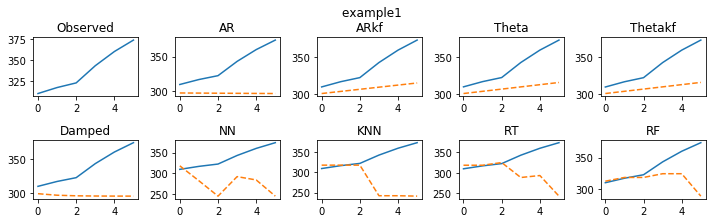

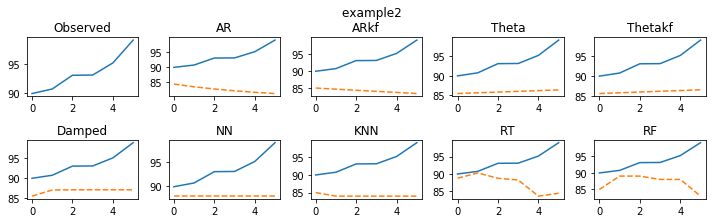

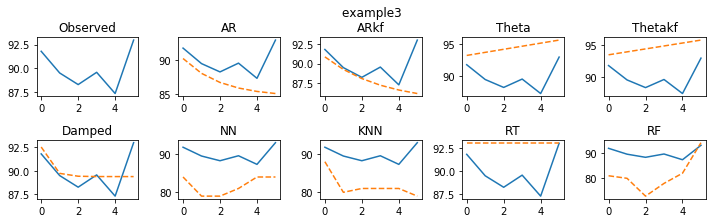

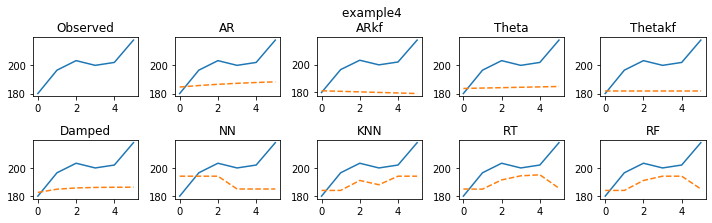

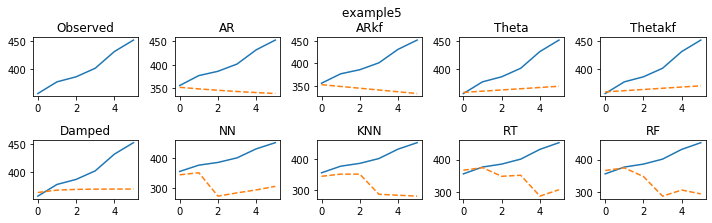

In [4]:
x = np.linspace(0, steps-1, steps)
for q in range(5):
    plt.figure(figsize=[10, 3])
    plt.tight_layout()
    plt.suptitle('        example' + str(q + 1), y=1.02)
    plt.subplot(2, 5, 1)
    plt.plot(x, np.array(MM.iloc[q][-steps:]))
    plt.title('Observed')
    for i in range(mcount):
        plt.subplot(2, 5, i+2)
        plt.plot(x, np.array(MM.iloc[q][-steps:]), x, locals()['Method' + str(i+1)][q], '--')
        plt.title(mlist[i])
        plt.tight_layout()
plt.show()

以上便是9种算法的预测结果，根据MASE和MAPE的数据，我们可以看出，**SSOE情况下的Theta模型**和**回归树模型（RT）**对这些金融数据有着较好的预测结果，我们可以在实际运用中使用这两种模型进行预测。